In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bbujp3_g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bbujp3_g
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
! cd ..

In [3]:
! mkdir ./.kaggle

In [4]:
! mv kaggle.json .kaggle/kaggle.json

In [5]:
!mv .kaggle /root/

In [6]:
! kaggle competitions download -c shopee-product-matching

100% 1.68G/1.68G [01:44<00:00, 21.9MB/s]
100% 1.68G/1.68G [01:44<00:00, 17.2MB/s]


In [7]:
! unzip shopee-product-matching.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_images/d8fce6d90ff1c758810b2132d8d9a84e.jpg  
  inflating: train_images/d90143423d8db45b382f2dee3d01fcb1.jpg  
  inflating: train_images/d903b2ab37c0418bfeb7e6e5304b64a4.jpg  
  inflating: train_images/d905748b1f61121cdcc7ae397b97052b.jpg  
  inflating: train_images/d906df4fdf70397d4f04ef0fe6ea1fe2.jpg  
  inflating: train_images/d9074f43948053971953322ed8ddc2cf.jpg  
  inflating: train_images/d9076a1375bb05c33edd5a1f1684e1f0.jpg  
  inflating: train_images/d9093fbb00a2013aad7cbcd993d779ab.jpg  
  inflating: train_images/d90ac3ff5b7d6371c50b3ef737002084.jpg  
  inflating: train_images/d90c105714e1475c4ef930e796570749.jpg  
  inflating: train_images/d90e64bea620d6e38ffe9f35b276c192.jpg  
  inflating: train_images/d9149fbfdf8d8d197f86e0a3d2ab7584.jpg  
  inflating: train_images/d914f6199e2dbafdd4a519c48dd1a5f4.jpg  
  inflating: train_images/d9159234afcf810fa9ddc7b2d49ce707.jpg  
  inflating: train_images/d91635194d9f939a71f55373311e

# Codes

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import os
import clip
import torch
from torchvision.datasets import CIFAR100
from torch.optim import AdamW
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [3]:
def random_split_list(lst, ratio):
    random.shuffle(lst)
    split_point = int(len(lst) * ratio)
    return lst[:split_point], lst[split_point:]


class CustomDatase_train(Dataset):
    def __init__(self, image_dir, data_csv, preprocess=None, text_preprocess=None):
        self.image_dir = image_dir
        self.data_csv = data_csv
        self.title = []
        self.image_name = []
        self.preprocess = preprocess
        self.text_preprocess = text_preprocess
        for i in range(len(self.data_csv)):
          self.title.append(self.data_csv[i]['title'])
          self.image_name.append(self.data_csv[i]['image'])

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):

        img_name = self.image_name[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)
        image = self.preprocess(image)
        text = self.title[idx]
        if len(text) > 75:
          text = text[:75]

        text = self.text_preprocess(text)

        return image, text


class CustomDatase_test(Dataset):
    def __init__(self, image_dir, data_csv, preprocess=None, text_preprocess=None):
        self.image_dir = image_dir
        self.data_csv = data_csv
        self.title = []
        self.image_name = []
        self.preprocess = preprocess
        self.text_preprocess = text_preprocess
        for i in range(len(self.data_csv)):
          self.title.append(self.data_csv[i]['title'])
          self.image_name.append(self.data_csv[i]['image'])

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):

        img_name = self.image_name[idx]
        img_path = os.path.join(self.image_dir, img_name)
        pil_image = Image.open(img_path)
        image = self.preprocess(pil_image)
        raw_text = self.title[idx]
        if len(raw_text) > 75:
          raw_text = raw_text[:75]

        text = self.text_preprocess(raw_text)

        return image, text, pil_image, raw_text

def custom_collate_fn(batch):
    tensor_images, tensor_text, pil_images, raw_text = zip(*batch)

    tensor_images = torch.stack(tensor_images, dim=0)
    tensor_text = torch.stack(tensor_text, dim=0)

    return tensor_images, tensor_text, pil_images, raw_text

def infonce_loss(similarity_matrix, temperature=0.1):
    n = similarity_matrix.size(0)
    positive_samples = torch.diag(similarity_matrix)
    similarity_matrix /= temperature
    exp_sim_matrix = torch.exp(similarity_matrix)
    sum_exp_sim_matrix = exp_sim_matrix.sum(dim=1)
    exp_positive_samples = torch.exp(positive_samples / temperature)
    loss = -torch.log(exp_positive_samples / sum_exp_sim_matrix)
    loss = loss.mean()

    return loss




**기학습된 데이터 셋이므로, 학습 이전에 test 성능평가**

test 개수 1000 개



1.  먼저 test 데이터셋에 있는 모든(1000개) 이미지를 feature 로 저장

전체 데이터셋 샘플 개수:  34250  train 데이터 수:  30825  test 데이터 수:  3425
Hijab Syiria plisket pita bahan kaos tk paud sd


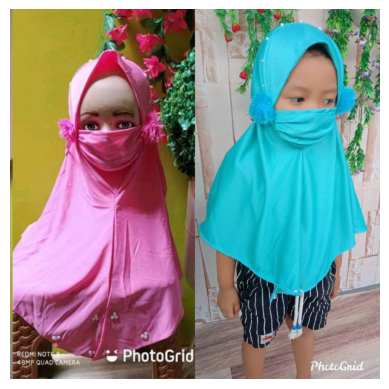




Earphone Headset Bluetooth Wireless Magnetic Sport Stereo


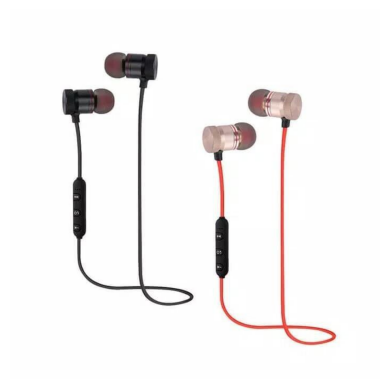




Simbicort 120 doses


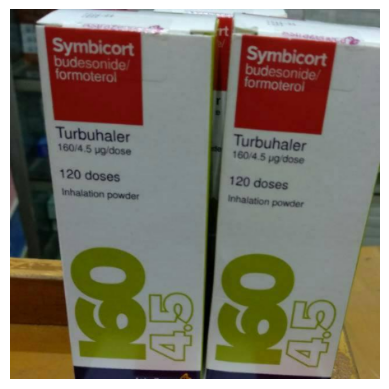




Karet sabuk aki Rx King Rxking Rxk CKD


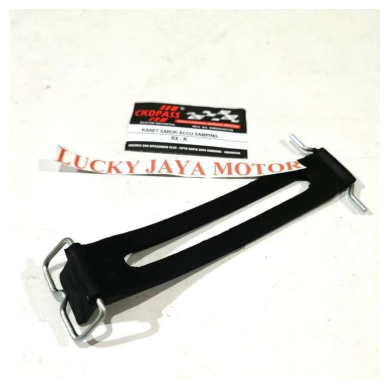




Bando tv uk 21 inc-32inc


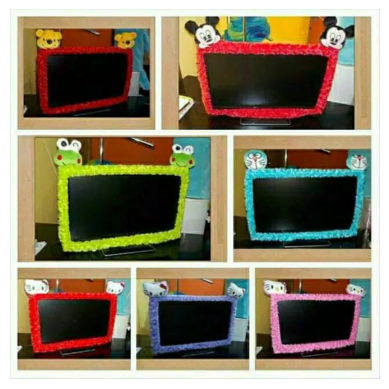




HEART SWEATER HOODIE (MOCCA) - PAKAIAN WANITA -  SWEATER HOODIE WANITA - AT


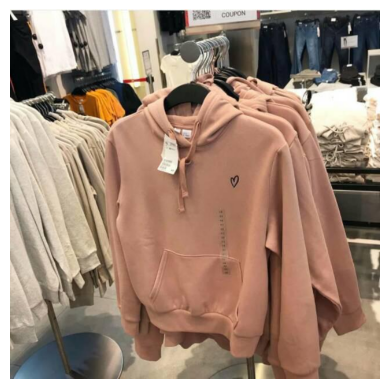




Saniter spray


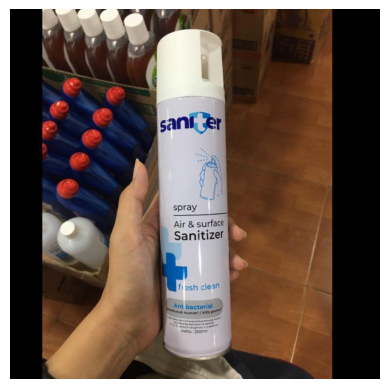




Samsung Galaxy Tab A 8.0 2019 T295 2/32 GB - Garansi Resmi


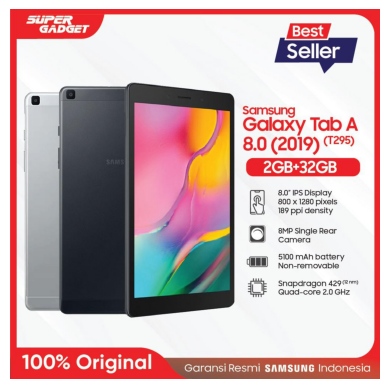




Senter tangan tenteng senter multipungsi village 5720 cod


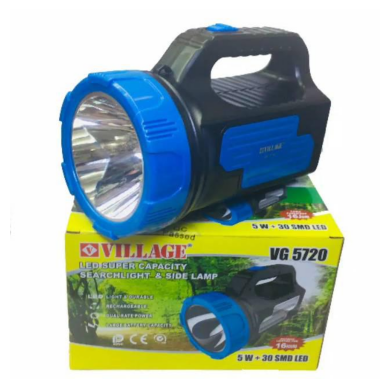




Tuner Gitar Digital Joyo JT-01 Clip On Chromatic Guitar Bass Ukulele


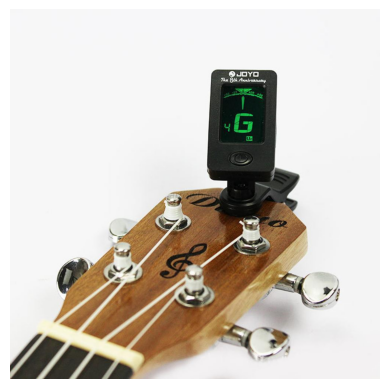

In [4]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
model = model.float()

optimizer = AdamW(model.parameters(), lr=1e-4)


data_csv = pd.read_csv('/content/train.csv')
data_csv = data_csv.to_dict(orient='records')
len_data =  len(data_csv)
print('전체 데이터셋 샘플 개수: ', len_data ,' train 데이터 수: ', int(len_data*0.9), ' test 데이터 수: ', len_data - int(len_data*0.9) )
train_data, test_data = random_split_list(data_csv, 0.9)

model.eval()
test_batch_size = 16

test_dataset = CustomDatase_test(image_dir='./train_images', data_csv=test_data[:1000], preprocess=preprocess, text_preprocess = clip.tokenize)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

count_show = 0
dataset_images_tensor = []
dataset_images = []

with torch.no_grad():
    for iter, data in enumerate(test_dataloader):
        image_features = model.encode_image(data[0].to(device))
        dataset_images_tensor.append(image_features)
        text_features = model.encode_text(data[1].squeeze(dim=1).to(device))

        dataset_images += list(data[2])
        if count_show < 10:
          print(data[3][0])
          plt.imshow(data[2][0])
          plt.axis('off')
          plt.show()
          count_show += 1
          print('\n\n')

dataset_images_tensor = torch.cat(dataset_images_tensor, dim=0)

2. 100개의 텍스트 또한 feature로 인코딩하고, 그 중 몇개가 레이블링 되어 있는 이미지와 유사도가 가장 큰지 확인 --> retrieval 성능

In [5]:
correct = 0
with torch.no_grad():
    for iter, data in enumerate(test_dataloader):
        text_features = model.encode_text(data[1].squeeze(dim=1).to(device))

        sim = torch.einsum('nd, md -> mn', F.normalize(dataset_images_tensor, dim=-1), F.normalize(text_features, dim=-1))
        _, max_idx = torch.max(sim, dim=-1)
        gt_start_idx = 16 * iter

        for i in range(len(max_idx)):
          if gt_start_idx + i == int(max_idx[i]):
            correct += 1

print('맞춘 개수: (', correct,'/1000)')

맞춘 개수: ( 359 /1000)


3. InfoNCE loss를 통한 학습

In [7]:
train_dataset = CustomDatase_train(image_dir='./train_images', data_csv=train_data, preprocess=preprocess, text_preprocess = clip.tokenize)
trian_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

model.train()
# Iterate through the dataset
loss_list = []
for epoch in range(5):
  for iter, data in enumerate(trian_dataloader):
      image_features = model.encode_image(data[0].to(device))
      text_features = model.encode_text(data[1].squeeze(dim=1).to(device))
      #print(image_features.shape , text_features.shape)
      sim = torch.einsum('nd, md -> nm', F.normalize(image_features, dim=-1), F.normalize(text_features,dim=-1))

      loss = infonce_loss(sim)
      loss_list.append( float(loss.item()) )
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if iter % 10 == 0:
        print(f"Epoch {epoch}, Iter{ iter }/{ len(trian_dataloader)} Loss: {sum(loss_list) / len(loss_list)}")
        loss_list = []


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Iter0/241 Loss: 3.8223800659179688
Epoch 0, Iter10/241 Loss: 3.9933861017227175
Epoch 0, Iter20/241 Loss: 3.161431407928467
Epoch 0, Iter30/241 Loss: 2.755434036254883
Epoch 0, Iter40/241 Loss: 2.5077725648880005
Epoch 0, Iter50/241 Loss: 2.338207149505615
Epoch 0, Iter60/241 Loss: 2.2024605512619018
Epoch 0, Iter70/241 Loss: 2.171158242225647
Epoch 0, Iter80/241 Loss: 2.0822736501693724
Epoch 0, Iter90/241 Loss: 1.9800023794174195
Epoch 0, Iter100/241 Loss: 1.8855698466300965
Epoch 0, Iter110/241 Loss: 1.9017948627471923
Epoch 0, Iter120/241 Loss: 1.8709754824638367
Epoch 0, Iter130/241 Loss: 1.7687223076820373
Epoch 0, Iter140/241 Loss: 1.7208187222480773
Epoch 0, Iter150/241 Loss: 1.7493107080459596
Epoch 0, Iter160/241 Loss: 1.7364864706993104
Epoch 0, Iter170/241 Loss: 1.6445778369903565
Epoch 0, Iter180/241 Loss: 1.621069347858429
Epoch 0, Iter190/241 Loss: 1.5968153476715088
Epoch 0, Iter200/241 Loss: 1.5453828573226929
Epoch 0, Iter210/241 Loss: 1.6043486833572387
Epoc

In [8]:
dataset_images_tensor = []
dataset_images = []
with torch.no_grad():
    for iter, data in enumerate(test_dataloader):
        image_features = model.encode_image(data[0].to(device))
        dataset_images_tensor.append(image_features)
        text_features = model.encode_text(data[1].squeeze(dim=1).to(device))
        dataset_images += list(data[2])

dataset_images_tensor = torch.cat(dataset_images_tensor, dim=0)

In [9]:
correct = 0
with torch.no_grad():
    for iter, data in enumerate(test_dataloader):
        text_features = model.encode_text(data[1].squeeze(dim=1).to(device))

        sim = torch.einsum('nd, md -> mn', F.normalize(dataset_images_tensor, dim=-1), F.normalize(text_features, dim=-1))
        _, max_idx = torch.max(sim, dim=-1)
        gt_start_idx = 16 * iter

        for i in range(len(max_idx)):
          if gt_start_idx + i == int(max_idx[i]):
            correct += 1

print('맞춘 개수: (', correct,'/1000)')

맞춘 개수: ( 562 /1000)
